In [1]:
import bioread as br
import scipy.signal as signal
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

sns.set_context('talk')

In [2]:
def iir_lowpass(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.iirfilter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

def comb_band_stop(notches, ts, Q, fs):
    import scipy.signal as signal
    filtered = ts
    for notch in notches:
        #print(notch)
        for i in np.arange(1, (nyquist / notches[notch])):
            #print(notches[notch] * i)
            f0 = notches[notch] * i
            w0 = f0/nyquist
            b,a = signal.iirnotch(w0, Q)
            filtered = signal.filtfilt(b, a, filtered)
    return filtered

## Read in the AcqKnowlege file from our pilot participant
Bioread is a python package for reading AcqKnowledge files into python as dictionaries. The second line just checks on the names of each channel and the data contained.

In [3]:
data = br.read_file('/Users/kbottenh/Downloads/sub-Blossom_ses-01.acq')
data.named_channels

{'ECG100C - ECG100C': Channel ECG100C - ECG100C: 12232309 samples, 2000.0 samples/sec, loaded: True,
 'DA100C - TSD221-MRI - Respiration Trans': Channel DA100C - TSD221-MRI - Respiration Trans: 12232309 samples, 2000.0 samples/sec, loaded: True,
 'EDA100C - EDA100C-MRI': Channel EDA100C - EDA100C-MRI: 12232309 samples, 2000.0 samples/sec, loaded: True,
 'Trigger': Channel Trigger: 12232309 samples, 2000.0 samples/sec, loaded: True}

In [4]:
data.named_channels['EDA100C - EDA100C-MRI'].units

'microsiemens'

## Organize timeseries into dataframe with common index (time)
Dictionaries are nice and all, but I can put the timeseries into one dataframe and then subset them more easily, as they'll all be organized according to a common timing index, from the AcqKnowledge file. This makes it easier to subset the data (i.e., extract EPI signal based on presence of 5V signal in the `digital input` channel.

In [5]:
#organizing data from the AcqKnowlege file into a pandas dataframe 
#one column per channel, with a common index (time)
timeseries = pd.DataFrame(columns=['EDA', 'EPI', 'seconds'])

timeseries['EPI'] = data.named_channels['Trigger'].data
timeseries['EDA'] = data.named_channels['EDA100C - EDA100C-MRI'].data
timeseries['seconds'] = data.time_index

## Extract timeseries collected during EPI scans
Where `Digital input` is 5V, there was an EPI scan running. We can calculate interfering freqencies by assessing the EDA signal during these segments of time.

fives = timeseries[timeseries['EPI'] == 5].index.values
scan_idx = consecutive(fives, stepsize=1)
scan_idx[3].shape

In [6]:
#separating timeseries collected during BOLD scan
#(where trigger channel = 5V)
epi_ts = timeseries[timeseries['EPI'] == 5]
epi_ts.drop(columns='EPI', inplace=True)

/Users/kbottenh/Library/Python/3.7/lib/python/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [25]:
timeseries.iloc[100000]

EDA          1.345825
EPI          5.000000
seconds    500.000041
Name: 1000000, dtype: float64

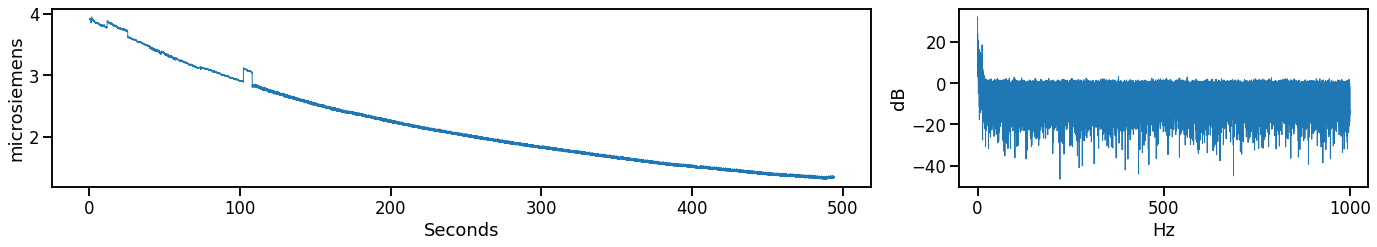

In [42]:
fft_eda = np.fft.fft(timeseries['EDA'][:100000])
freq = np.fft.fftfreq(timeseries['EDA'][:100000].shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_eda.real))

gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,4))
plt.tight_layout(pad=2)
sns.lineplot(signal.decimate(timeseries['seconds'], 10)[:100000], 
             signal.decimate(timeseries['EDA'], 10)[:100000], 
             linewidth=1., ax=ax1) #array, top subplot
sns.lineplot(freq[freq > 0], fft_eda_db[freq > 0], linewidth=1., ax=ax2) #bottom subplot
ax1.set_xlabel('Seconds')
ax1.set_ylabel('microsiemens')
ax2.set_xlabel('Hz')
ax2.set_xticks([0, 500, 1000])
ax2.set_ylabel('dB')
fig.savefig('me_sms-eda-pre-scan.png', dpi=300)
plt.show()

## Filtering the data!
First, we did a Fourier transform on the EPI-corrupted ECG signal to look for interfering freqiencies. We plotted the Fourier transformed data, as well as the log-transformed Fourier transformed data, for signal power in decibels.

In [8]:
st_s01e01r01.std()

EDA          0.458286
seconds    146.647053
dtype: float64

In [9]:
fft_eda = np.fft.fft(epi_ts['EDA'])
freq = np.fft.fftfreq(epi_ts['EDA'].shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_eda.real))

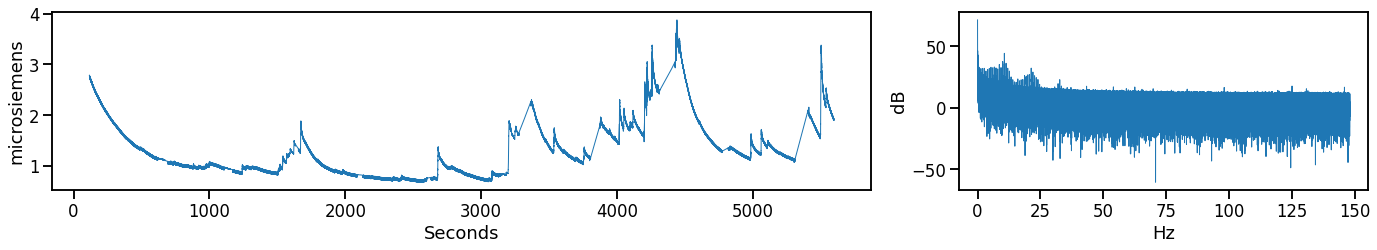

In [10]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,4))
plt.tight_layout(pad=2)
sns.lineplot(signal.decimate(epi_ts['seconds'], 10)[:1000000], 
             signal.decimate(epi_ts['EDA'], 10)[:1000000], 
             linewidth=1., ax=ax1) #array, top subplot
sns.lineplot(freq[:800000], fft_eda_db[:800000], linewidth=1., ax=ax2) #bottom subplot
ax1.set_xlabel('Seconds')
ax1.set_ylabel('microsiemens')
ax2.set_xlabel('Hz')
ax2.set_ylabel('dB')
fig.savefig('me_sms-eda-fft.png', dpi=300)
plt.show()

In [11]:
#arranging noisy frequencies to be filtered out
slices = 48
mb = 3
tr = 1.5

notches = {'te1': 1 / 0.01180, #I'm not sure the TEs are necessary?  
           'te2': 1 / 0.02804, #Or that they should be treated like this?
           'te3': 1 / 0.04428,
           'te4': 1 / 0.06052, 
           'slices': slices / mb / tr, 
           'tr': 1 / 1.5}      #turns out those evenly-spaced interfering frequencies are 0.66Hz apart


fs = 2000.

#I don't know if this is right, been playing around with the volume of Q
Q = 100

nyquist = fs/2

In [12]:
filtered_eda_lp = iir_lowpass(epi_ts['EDA'], 15, fs, 3)
fft_eda = np.fft.fft(filtered_eda_lp.real)
freq = np.fft.fftfreq(filtered_eda_lp.real.shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_eda.real))

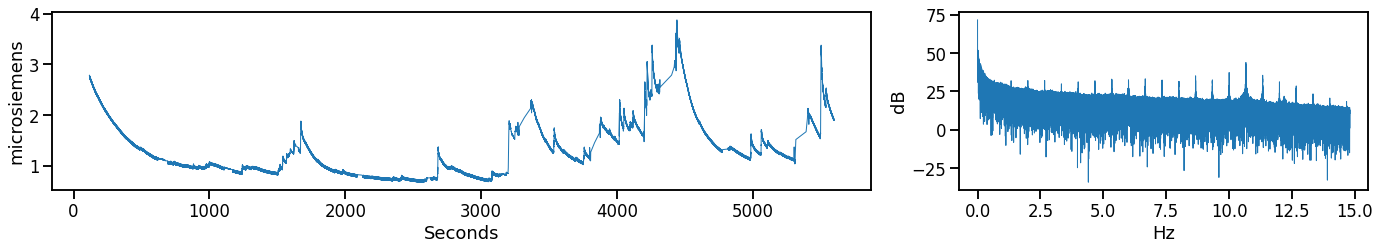

In [14]:
gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,4))
plt.tight_layout(pad=2)
sns.lineplot(signal.decimate(epi_ts['seconds'], 10)[:1000000], 
             signal.decimate(filtered_eda_lp, 10)[:1000000],
             linewidth=1., ax=ax1) #array, top subplot
sns.lineplot(freq[:80000], fft_eda_db[:80000], linewidth=1., ax=ax2) #bottom subplot
ax1.set_xlabel('Seconds')
ax1.set_ylabel('microsiemens')
ax2.set_xlabel('Hz')
ax2.set_ylabel('dB')
fig.savefig('me_sms-eda-fft_lp.png', dpi=300)
plt.show()

In [15]:
filtered_eda = comb_band_stop(notches, st_s01e01r01['EDA'], Q, fs)

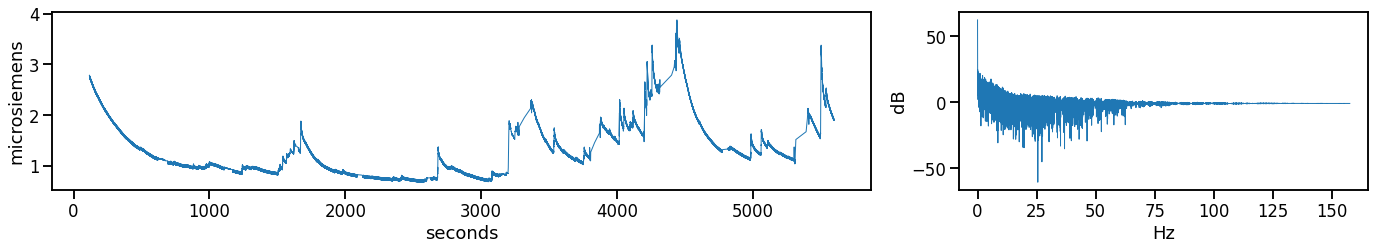

In [16]:
fft_eda = np.fft.fft(filtered_eda.real)
freq = np.fft.fftfreq(filtered_eda.real.shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_eda.real))

gridkw = dict(width_ratios=[2,1])
fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw=gridkw, figsize=(20,4))
plt.tight_layout(pad=2)
sns.lineplot(signal.decimate(epi_ts['seconds'], 10)[:1000000], 
             signal.decimate(filtered_eda_lp, 10)[:1000000], 
             linewidth=1., ax=ax1) #array, top subplot
sns.lineplot(freq[:80000], fft_eda_db[:80000], linewidth=1., ax=ax2) #bottom subplot
ax1.set_xlabel('seconds')
ax1.set_ylabel('microsiemens')
ax2.set_xlabel('Hz')
ax2.set_ylabel('dB')
fig.savefig('me_sms-eda-fft_lp+cbs.png', dpi=300)
plt.show()

In [17]:
filtered_eda = signal.decimate(filtered_eda, 20)

KeyboardInterrupt: 

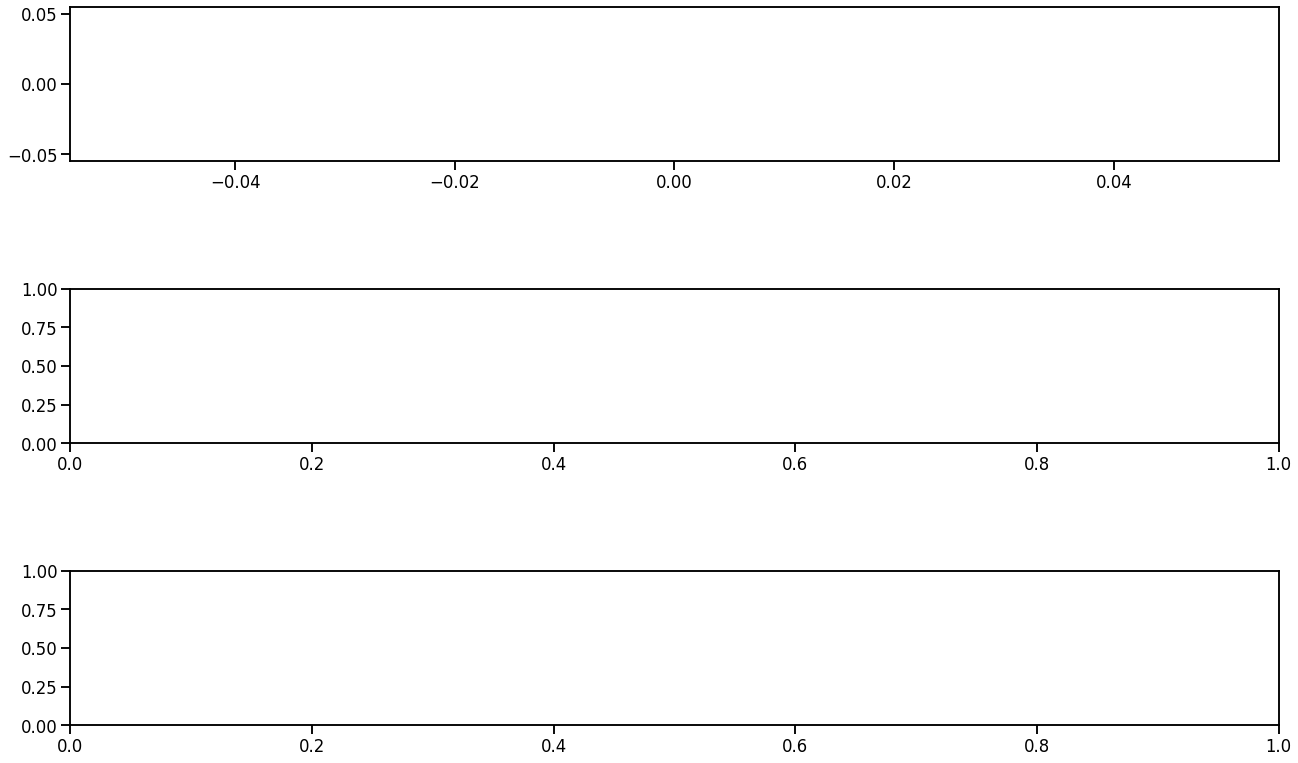

In [18]:
x = np.arange(0, filtered_eda.shape[0])
x2 = np.arange(0, filtered_eda_lp.shape[0])

fig,ax = plt.subplots(nrows=3, figsize=(20,13), sharey=False)
plt.tight_layout(pad=5)
g = sns.lineplot(epi_ts['seconds'], epi_ts['EDA'], ax=ax[0])
g.set_title('Unfiltered EDA signal')
h = sns.lineplot(x2, filtered_eda_lp, ax=ax[1])
h.set_title('Lowpass EDA signal')
h = sns.lineplot(x, filtered_eda, ax=ax[2])
h.set_title('Lowpass + decimated EDA signal')

In [ ]:
fft_eda = np.fft.fft(filtered_eda.real)
freq = np.fft.fftfreq(filtered_eda.real.shape[-1], d=0.0005)
fft_eda_db = 10 * np.log10(abs(fft_eda.real))

In [ ]:
fig,ax = plt.subplots(nrows=1, ncols=2, figsize=(10,7), sharex=True)
j = sns.lineplot(freq[:10000], fft_eda.real[:10000], ax=ax[0])
j.set_title('Fourier Transform: Filtered + low-pass EDA')
j.set_xlabel('Hz')
k = sns.lineplot(freq[:10000], fft_eda_db.real[:10000], ax=ax[1])
k.set_title('Fourier Transform: Filtered + low-pass EDA signal db')
k.set_xlabel('Hz')
#fig.savefig('me_sms-eda-fft.png', dpi=300)